In [1]:
# (Optional) only if libraries aren't installed in your environment:
# !pip install -q scikit-learn pandas matplotlib joblib

# Step 1: imports and basic settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import joblib

%matplotlib inline


In [5]:
# Step 2: load CSV (put Iris.csv in the same folder in Colab or provide path)
df = pd.read_csv('Iris.csv')   # change path if needed
# drop Id column if present
if 'Id' in df.columns:
    df = df.drop('Id', axis=1)
df.head()


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
# Step 3: detect likely label column and inspect
label_col = None
for c in ['species','Species','class','Class','label','Label','target','Target']:
    if c in df.columns:
        label_col = c
        break
if label_col is None:
    raise ValueError("Could not find label column automatically. Edit the code to set label_col manually.")

print("Label column detected:", label_col)
print(df.info())
print("Class distribution:")
print(df[label_col].value_counts())


Label column detected: Species
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
Class distribution:
Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64


In [7]:
# Step 4: features and labels
X = df.drop(label_col, axis=1).values
y = df[label_col].values

# encode labels to integers
le = LabelEncoder()
y_enc = le.fit_transform(y)

# train-test split (stratify to keep class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2,
                                                    random_state=42, stratify=y_enc)

# standardize features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


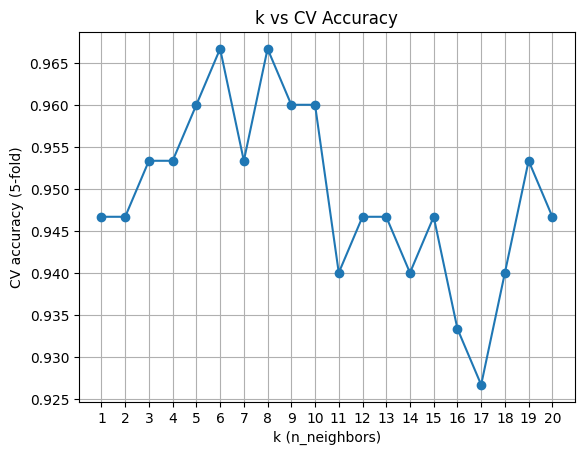

Best k by CV: 6 with CV accuracy: 0.9666666666666668


In [8]:
# Step 5: search best k using 5-fold CV (try odd ks to avoid ties)
ks = list(range(1, 21))  # 1..20
cv_scores = []
# scale whole X for CV
X_scaled_all = StandardScaler().fit_transform(X)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_scaled_all, y_enc, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# show results & best k
import matplotlib.pyplot as plt
plt.plot(ks, cv_scores, marker='o')
plt.xlabel('k (n_neighbors)')
plt.ylabel('CV accuracy (5-fold)')
plt.title('k vs CV Accuracy')
plt.xticks(ks)
plt.grid(True)
plt.show()

best_k = ks[int(np.argmax(cv_scores))]
print("Best k by CV:", best_k, "with CV accuracy:", max(cv_scores))


Test Accuracy: 0.9333333333333333

Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



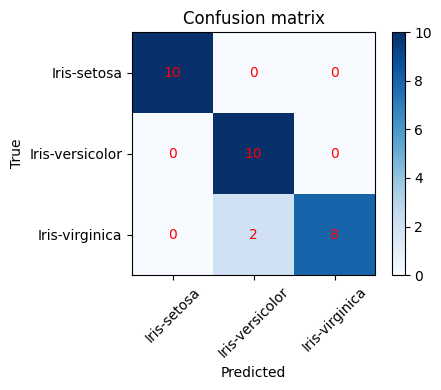

In [9]:
# Step 6: train with best_k and evaluate
best_k = int(best_k)  # ensure int
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# confusion matrix (visual)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(range(len(le.classes_)), le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()


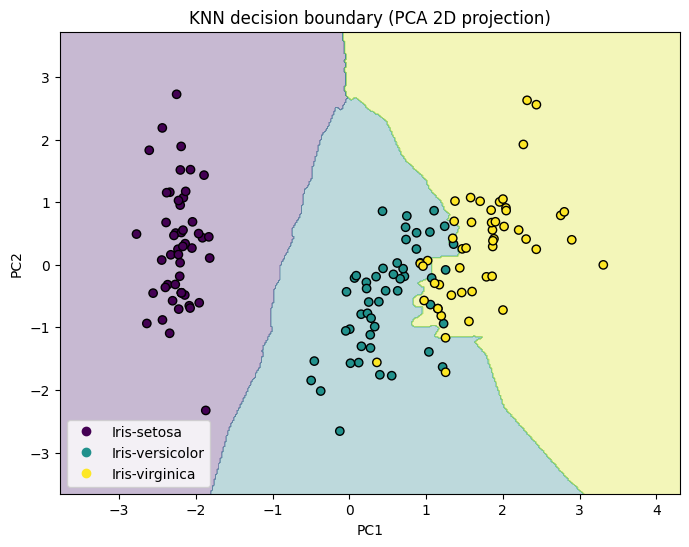

In [10]:
# Step 7: project features to 2D using PCA and visualize decision boundaries
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))  # scale then PCA
y_all = y_enc

# train-test split on PCA space for plotting (optional)
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_all, test_size=0.2, random_state=42, stratify=y_all)

knn_pca = KNeighborsClassifier(n_neighbors=best_k)
knn_pca.fit(X_pca_train, y_pca_train)

# mesh grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_all, edgecolor='k')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('KNN decision boundary (PCA 2D projection)')
plt.legend(handles=scatter.legend_elements()[0], labels=list(le.classes_))
plt.show()


In [11]:
# Step 8: save artifacts so you can load later
joblib.dump(model, 'knn_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le, 'label_encoder.joblib')
print("Saved: knn_model.joblib, scaler.joblib, label_encoder.joblib")


Saved: knn_model.joblib, scaler.joblib, label_encoder.joblib


In [12]:
# Step 9: predict on new sample (use original feature order)
sample = [[5.1, 3.5, 1.4, 0.2]]     # example (sepal_len, sepal_wid, petal_len, petal_wid)
sample_scaled = scaler.transform(sample)
pred_idx = model.predict(sample_scaled)
pred_label = le.inverse_transform(pred_idx)
print("Predicted class:", pred_label[0])


Predicted class: Iris-setosa
